In [2]:
%matplotlib inline
%pylab inline

import pandas as pd
import matplotlib.pyplot as plt
import plotly
import numpy as np
import seaborn as sns
import calendar
import pandasql as pdsql
from scipy.stats import linregress
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import  bootstrap_plot
from sklearn import linear_model
from sklearn import preprocessing
#from sklearn.model_selection import train_test_split
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import requests
import io
import os 
import time
import pickle
import matplotlib.dates as md
import datetime
pylab.rcParams['figure.figsize'] = (17, 13)

#import matplotlib.pyplot as plt
#import plotly
#import seaborn as sns
#import calendar
#from scipy.stats import linregress
#from pandas.tools.plotting import autocorrelation_plot
#from pandas.tools.plotting import lag_plot
#from pandas.tools.plotting import  bootstrap_plot
#pysql = lambda q: pdsql.sqldf(q, globals())
#pysql_loc = lambda q: pdsql.sqldf(q, locals())



Populating the interactive namespace from numpy and matplotlib


In [2]:
datetime.datetime

datetime.datetime

In [29]:
def load_911db_realtime():    
    url="https://storage.googleapis.com/montco-stats/tz.csv"
    d=requests.get(url).content
    d=pd.read_csv(io.StringIO(d.decode('utf-8')), header=0,names=['lat', 'lng','desc','zip','title','timeStamp','twp','e'],dtype={'lat':float,'lng':float,'desc':str,'zip':str,'title':str,'timeStamp':str,'twp':str,'e':int})   
    d=pd.DataFrame(d)
    return d

def save_911db(df, dir, name):
    df.to_csv(dir + name)


def load_911db_local():
    d = [];
    d=pd.read_csv('../data/911db_all_20170621_21_53.csv', header=0,names=['lat', 'lng','desc','zip','title','timeStamp','twp','e'],dtype={'lat':float,'lng':float,'desc':str,'zip':str,'title':str,'timeStamp':str,'twp':str,'e':int})    
    d=pd.DataFrame(d)
    return d

# type_db = 1 'EMS'
# type_db = 2 'Fire'
# type_db = 3 'Traffic'
# type_db = any number 'all'
def get_db_type(DB, type_db):
    
    
    if type_db == 1:
        sql1 = "select * from DB where title like 'EMS:%'"
        d3 = pdsql.sqldf(sql1, {'DB':DB})
        return pd.DataFrame(d3)
    
    if type_db == 2:
        sql1 = "select * from DB where title like 'Fire:%'"
        d3 = pdsql.sqldf(sql1, {'DB':DB})
        return pd.DataFrame(d3)
    
    if type_db == 3:
        sql1 = "select * from DB where title like 'Traffic:%'"
        d3 = pdsql.sqldf(sql1, {'DB':DB})
        return pd.DataFrame(d3)
    
    return DB

def add_data_time_columns(dt): 
    
    # ADD THE DATE AND TIME IN SINGLE COLUMNS FOR GROUPPING THE CALLS BY HOURS
    dt1 = np.zeros((dt.shape[0], 4))

    for i in range(0,dt.shape[0]):
        s = dt.timeStamp[i]
        s = s.split(' ')
        ymd = s[0]. split('-')
        hms = s[1]. split(':')
        dt1[i,0]=int(ymd[0])
        dt1[i,1]=int(ymd[1])
        dt1[i,2]=int(ymd[2])
        dt1[i,3]=int(hms[0])

    dt1 = pd.DataFrame(dt1)
    dt2 = pd.concat([dt,dt1], axis=1)

    names = dt2.columns.tolist()
    names[names.index(0)] = 'year'
    names[names.index(1)] = 'month'
    names[names.index(2)] = 'day'
    names[names.index(3)] = 'hour'
    dt2.columns = names
    dt2 = pd.DataFrame(dt2)
    
    # RE-INDEX WITH THE TIME STAMP
    #pysql_loc = lambda q: pdsql.sqldf(q, locals())
    #dt3 = pysql_loc("select timeStamp, year, month, day, hour, count(*) as calls from TAB1 where title like 'EMS:%' group by year, month, day, hour")
    sql1 = "select timeStamp, year, month, day, hour, count(*) as calls from dt2 where title like 'EMS:%' group by year, month, day, hour"
    dt3 = pdsql.sqldf(sql1, {'dt2':dt2})
    dt3 = pd.DataFrame(dt3)
    dt4 = dt3.set_index('timeStamp')
    del dt4.index.name
    
    return dt4




In [52]:
#df_all = load_911db_local()
df_all = load_911db_realtime()


In [61]:
# ---------------
# LOAD DB
# --------------

df_all = load_911db_realtime()
df_ems = get_db_type(df_all, 1)
df_model = add_data_time_columns(df_ems)

In [60]:
# BUILD A SMALL DATASET
t = '2017-03-01 12:00:00'
df_small = df_ems[df_ems.timeStamp > t]
db_name = '911db_small_' + time.strftime("%Y%m%d_%H_%M") + '.csv'
sdir1 = os.getcwd() + '/'
sdir2 = '../data/'
save_911db(df_small, sdir2, db_name)

df_small

,lat,lng,desc,zip,title,timeStamp,twp,e
85616,40.130193,-75.123971,PROSPECT AVE & WASHINGTON AVE; ABINGTON; Stat...,19090,EMS: SYNCOPAL EPISODE,2017-03-01 12:17:02,ABINGTON,1
85617,40.230934,-75.522125,LONGVIEW RD & RR UNDERPASS; LIMERICK; Station...,19468,EMS: NAUSEA/VOMITING,2017-03-01 12:32:00,LIMERICK,1
85618,40.022020,-75.240736,HARVEST CIR & SMITH DR; LOWER MERION; Station...,19004,EMS: RESPIRATORY EMERGENCY,2017-03-01 12:32:00,LOWER MERION,1
85619,40.226988,-75.164466,PARK RD & W COUNTY LINE RD; HORSHAM; Station ...,18976,EMS: CVA/STROKE,2017-03-01 12:42:01,HORSHAM,1
85620,40.153754,-75.121604,EASTON RD & LAWNTON RD; UPPER MORELAND; Stati...,19090,EMS: FALL VICTIM,2017-03-01 12:46:01,UPPER MORELAND,1
85621,40.113813,-75.345120,LAFAYETTE ST & SWEDE ST; NORRISTOWN; Station ...,19401,EMS: SEIZURES,2017-03-01 12:52:01,NORRISTOWN,1
85622,40.251174,-75.643975,EVANS ST & JEFFERSON AVE; POTTSTOWN; Station ...,19464,EMS: SEIZURES,2017-03-01 13:02:00,POTTSTOWN,1
85623,40.066597,-75.120248,BROOKVIEW PL & ASHBOURNE RD; CHELTENHAM; Stat...,19027,EMS: NAUSEA/VOMITING,2017-03-01 13:02:01,CHELTENHAM,1
85624,39.998215,-75.271290,WYNNEWOOD RD & LANCASTER AVE; LOWER MERION; S...,19096,EMS: OVERDOSE,2017-03-01 13:02:01,LOWER MERION,1
85625,40.115249,-75.341379,DEKALB ST; NORRISTOWN; Station 308A; 2017-03-...,None,EMS: HEAD INJURY,2017-03-01 13:02:02,NORRISTOWN,1


In [14]:
# ---------------
# SAVE UPDATED DB
# ---------------
#df_all = load_911db_realtime()
df_all = df_small
df_model = add_data_time_columns(df_all)
db_name_model = '911db_model_' +  time.strftime("%Y%m%d_%H_%M") + '.csv'
db_name_all = '911db_all_' + time.strftime("%Y%m%d_%H_%M") + '.csv'
sdir1 = os.getcwd() + '/'
sdir2 = '../data/'
save_911db(df_model, sdir2, db_name_model)
save_911db(df_all, sdir2, db_name_all)

# ---------------

'2017-06-21 00:00:00'

In [23]:
# this function creates the features values for the model 

# feature values <T-1>, <T-2> ... <T-n> 

    # n = num_past_events 
    
    # hours_single_event:
    # T-1 can be a sequence or time window wich is then averaged (<T-1>). 
    #The size of teh indow is given from hours_single_event

    # period_part_events is the step of the sliding window

    # uncommet the DEBUG section to see the index of the time widows

# feature values:  Year, month, day, hour

# feature values:  polynomial features given from degree (if >1)

def get_feature_values(df, time_in, DEGREE, REPEATS, SHIFT,WIN_HOURS):
        
    feature_CALLS = np.zeros(REPEATS)
    feature_STATS = np.zeros(3)
    feature_DATETIME_YMDH = np.zeros(4)
    
    #time_in = pd.to_datetime(time_in)
    #print(type(time_in))
    # SPLIT IN PAST AND FUTURE
    df_past = df[df.index<time_in]
    #df_future = df[df.index>date]

    if df_past.shape[0]<1:
        return -1
    
    # CALLS FEATUREs VALUES (7)
    for i in range(0,REPEATS):
        j = (df_past.shape[0]-WIN_HOURS)-i
        j = j-(i*(SHIFT-1))
        feature_CALLS[REPEATS-i-1] = int(mean(df_past.calls[j:j+WIN_HOURS])) # calculate mean from a small interv around the point
        #DEBUG----------------------------------------------------------------
        #print(str("x:") +  str(j) + str("-") + str(j+WIN_HOURS-1))
        #-----------------------------------------------------------------
    
    
    # STATS (2)
    feature_STATS[0] = np.std(feature_CALLS)
    feature_STATS[1] = np.mean(feature_CALLS)
    LEN_TOT_X = (WIN_HOURS-(WIN_HOURS-SHIFT))*(REPEATS-1)+WIN_HOURS
    feature_STATS[2] =  np.abs(feature_CALLS[0]-feature_CALLS[REPEATS-1])/LEN_TOT_X


    # DATE TIME FEATUREs VALUES(4)
    feature_DATETIME_YMDH[0] = int(df_past.year[df_past.shape[0]-1])
    feature_DATETIME_YMDH[1] = int(df_past.month[df_past.shape[0]-1])
    feature_DATETIME_YMDH[2] = int(df_past.day[df_past.shape[0]-1])
    feature_DATETIME_YMDH[3] = int(df_past.hour[df_past.shape[0]-1])

    feature_VALUES = np.concatenate((feature_STATS,feature_DATETIME_YMDH,feature_CALLS,), axis=0)

    # POLYNOMIAL FEATUREs VALUES 
    #feature_VALUES = feature_VALUES.reshape((len(feature_VALUES), 1))
    if(DEGREE>1):
        degree = 3
        p = PolynomialFeatures(DEGREE,  include_bias=True)
        feature_VALUES = p.fit_transform(feature_VALUES)

    return feature_VALUES


# this takes the y (mean of y[0:num_hours]) of the test data 
# it is used only to test the prediction
def get_knownvalues_single(df, time, WIN_HOURS):
    df_future = df[df.index>=time]
    if df_future.shape[0]<WIN_HOURS:
        return -1
    y = np.mean(df_future.calls[0:WIN_HOURS])
    return y 

def get_prediction(features_vals, model_dir, model_type):
    #model_ser = pickle.load(open('../model/911serial_model.sav', 'rb'))
    #scaler_ser = pickle.load(open('../model/911serial_scaler.sav', 'rb'))
    sdir = model_dir + '/' + model_type + '/'
    model_ser = pickle.load(open(sdir + '911_model.sav', 'rb'))
    scaler_ser = pickle.load(open(sdir + '911_scaler.sav', 'rb'))
    features_vals_scal = scaler_ser.transform(features_vals)     
    y = model_ser.predict(features_vals_scal)
    return y

  
# add the current predicted value at the end of the data frame to get the new data frame ready for 
# fro the next prediction from the old one and so on ...
# df_in:      data frame
# calls:      the number of predicted calls 
# step_hours: the numeber of hours to add calculating the prediction time
# return the a new dataframe 
def add_new_row(df, calls, step_hours):
    time_last = df.index[df.shape[0]-1]
    time_next = pd.to_datetime(time_last) + pd.Timedelta(hours=step_hours)
    row = [time_next.year, time_next.month, time_next.day, time_next.hour, calls ]
    df.loc[str(time_next)] = row    
    return df



In [25]:
def get_knownvalues_multi(dt2, time0,time1, WIN_HOURS):

    if dt2[dt2.index>time1].shape[0]<WIN_HOURS:
        return -1 
    
    datelist = pd.date_range(time0, time1, freq='1H').tolist()
    n = len(datelist)
    
    y = zeros(n)

    for i in range(0,n):
        time = datelist[i].strftime("%Y-%m-%d %H:%M:%S")
        y[i] = get_knownvalues_single(dt2, time, WIN_HOURS)

    return y

def get_prediction_multi(model_type, dt2, time0,time1, DEGREE, REPEATS, STEP, WIN_HOURS):
 
    if dt2[dt2.index<time1].shape[0]<(REPEATS*WIN_HOURS):
        return -1 
    
    datelist = pd.date_range(time0, time1, freq='1H').tolist()
    n = len(datelist)
    
    y = zeros(n)

    for i in range(0,n):
        time = datelist[i].strftime("%Y-%m-%d %H:%M:%S")
        #print(time)
        x = get_feature_values(dt2, time, DEGREE, REPEATS,STEP,WIN_HOURS)
        y[i] = get_prediction(x, '../model', model_type)
       
    return y
        

In [26]:
time0 = '2017-04-01 10:00:00'
time1 = '2017-06-17 10:00:00'
df_model[df_model.index<time1].shape[0]< REPEATS*WIN_HOURS
#dt2[dt2.index<time1]
#df_model[df_model.index<time0]




NameError: name 'y_new' is not defined

In [73]:
# TEST CALLS ------------------------------

DEGREE = 3
SHIFT = 24
WIN_HOURS = 4
WIN_HOURS_TRAIN = 2
REPEATS = 4

time0 = '2017-05-10 10:00:00'
time1 = '2017-06-10 10:00:00'


#feature_vals = get_feature_values(df_model, time1, DEGREE, REPEATS,SHIFT,WIN_HOURS) # sing sequence of features

y_test = get_knownvalues_multi(df_model, time0, time1, WIN_HOURS_TRAIN)
y_new = get_prediction_multi('linear_regression', df_model, time0,time1, DEGREE, REPEATS, SHIFT, WIN_HOURS)
    

#y_test = get_feature_values_y(dt2, time, HOURS) # it is a single value to test linear_regression
#y_pred = get_prediction(feature_vals)



/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/matplotlib/cbook.py:2641: UserWarning:

Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'



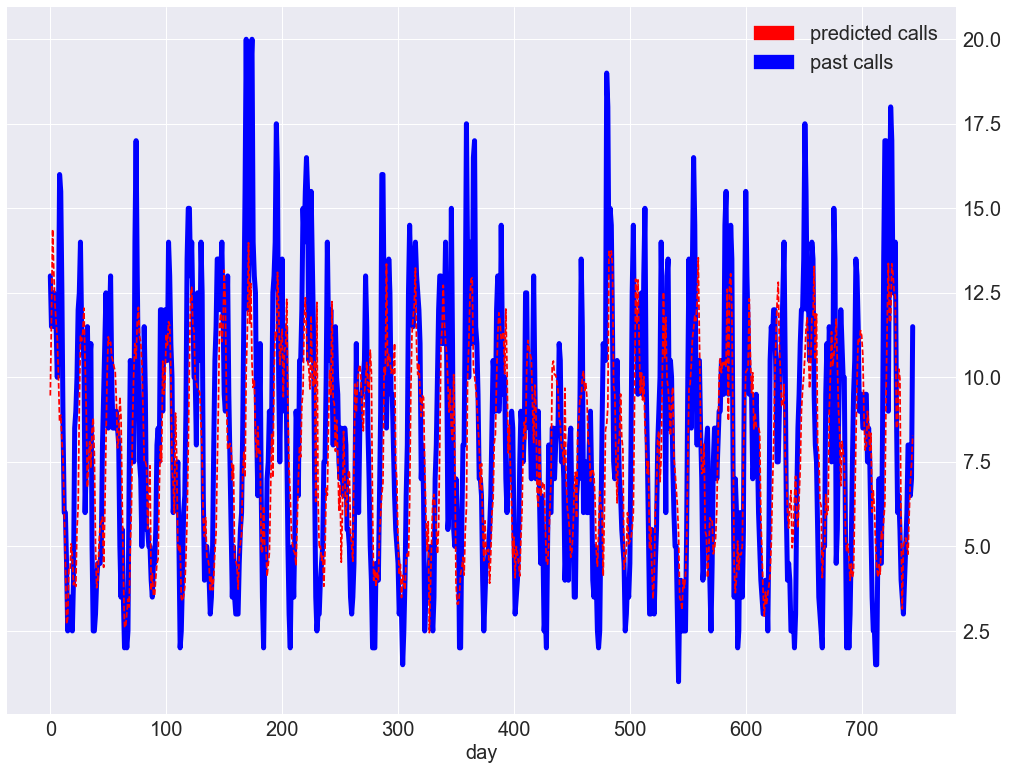

In [74]:
#df_model
#plt.plot(y_test[0:502], 'b', markersize=30, lw=6, linewidth=5)
#plt.plot(y_new[3:505], '--r')

plt.plot(y_test, 'b', markersize=10, lw=6, linewidth=5)
plt.plot(y_new, '--r')

#plt.xlabel('Time (hour)', fontsize=20)
plt.xlabel('day', fontsize=20)
#plt.ylabel('Calls', fontsize=20)
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on', labelsize=20)
plt.tick_params(axis='x',  labelsize=20)

plt.legend(handles=[red_patch, blue_patch], fontsize=20)
plt.show()



/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/matplotlib/cbook.py:2641: UserWarning:

Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'



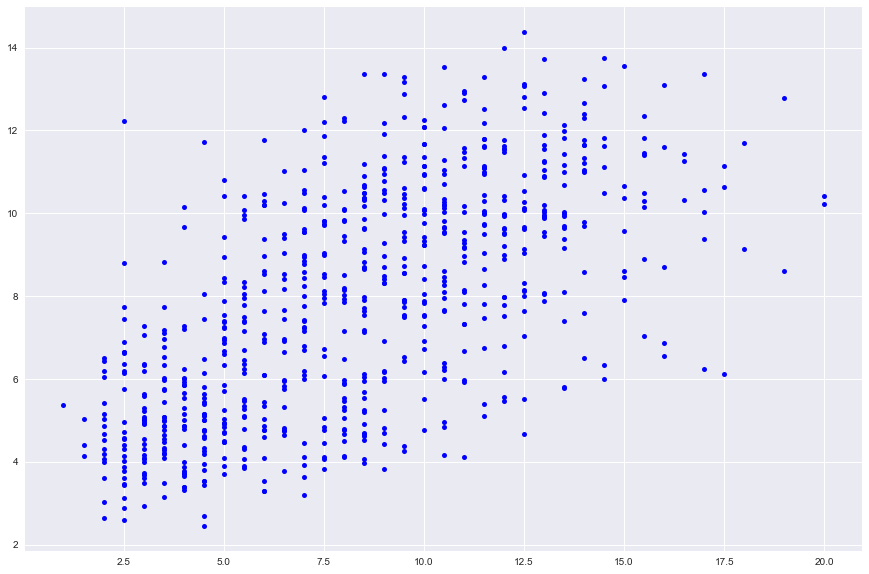

In [668]:
#plt.plot( y_test[0:502], y_new[3:505],'.b', markersize=10, lw=6, linewidth=5, )

plt.plot( y_test, y_new,'.b', markersize=10, lw=6, linewidth=5, )


In [41]:
DEGREE = 3
SHIFT = 24
WIN_HOURS = 4
WIN_HOURS_TRAIN = 2
REPEATS = 4

ITERS = 24

#time0 = '2017-05-10 10:00:00'
time1 = '2017-06-17 10:00:00'



def predict_future(df_in, TIME_PRED_START, PREDICTION_HOURS_CYCLES, DEGREE, REPEATS, SHIFT, WIN_HOURS, WIN_HOURS_TRAIN ):

    y_pred = zeros(PREDICTION_HOURS_CYCLES)
    x_pred = ["" for x in range(PREDICTION_HOURS_CYCLES)]
    y_test = []
    x_test = []

    df = df_in.copy()
    for i in range(0,PREDICTION_HOURS_CYCLES):
        #print(time1)
        x = get_feature_values(df, TIME_PRED_START, DEGREE, REPEATS,SHIFT,WIN_HOURS)
        y_pred[i] = get_prediction(x, '../model', 'linear_regression')
        y = get_knownvalues_single(df_in, TIME_PRED_START, WIN_HOURS_TRAIN)
        TIME_PRED_START = pd.to_datetime(TIME_PRED_START) + pd.Timedelta(hours=1)
        if y >0:
            y_test = np.append(y_test, y)
            x_test = np.append(x_test, TIME_PRED_START)

        df = add_new_row(df, y_pred[i], 1)
        x_pred[i] = TIME_PRED_START
        TIME_PRED_START = TIME_PRED_START.strftime('%Y-%m-%d %H:%M:%S')

    return x_pred, y_pred, x_test, y_test


# parameters from model
DEGREE = 3
SHIFT = 24
WIN_HOURS = 4
WIN_HOURS_TRAIN = 2
REPEATS = 4

PREDICTION_HOURS_CYCLES = 23
TIME_PRED_START = '2017-06-18 00:00:00'

x_p,y_p,x_t,y_t = predict_future(df_model, TIME_PRED_START, PREDICTION_HOURS_CYCLES, DEGREE, REPEATS, SHIFT, WIN_HOURS,WIN_HOURS_TRAIN )


/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

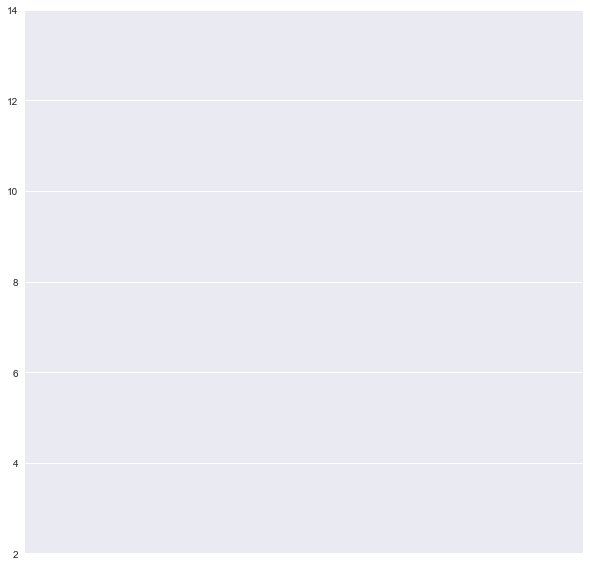

In [29]:
pylab.rcParams['figure.figsize'] = (10, 10)

def show_predict_future(x_pred, y_pred, x_test, y_test):
    
    n_test = len(x_test)
    n_pred= len(x_pred)
    
    ax=plt.gca()
    ax.set_xticks(x_pred)

    xfmt = md.DateFormatter('%H:00')
    ax.xaxis.set_major_formatter(xfmt)
    plt.xticks( rotation=25 )

    plt.plot(x_pred[0:n_test], y_pred[0:n_test],'.c', markersize=260)
    plt.plot(x_pred[n_test:n_pred], y_pred[n_test:n_pred],'.r', markersize=260)
    plt.plot(x_pred[n_test:n_pred], y_pred[n_test:n_pred],'.w', markersize=20)
    plt.plot(x_pred[n_test:n_pred], y_pred[n_test:n_pred],'-w', markersize=20)
    plt.plot(x_test, y_test,'-b', markersize=40)
    plt.plot(x_test, y_test,'.b', markersize=40)
    plt.axis(['00:00', '23:00', 2, 14])
    plt.show()



#PREDICTION_HOURS_CYCLES = 24
#TIME_PRED_START = '2017-06-18 01:00:00'
#x_p,y_p,x_t,y_t = predict_future(df_model, TIME_PRED_START, PREDICTION_HOURS_CYCLES, DEGREE, SHIFT, WIN_HOURS,WIN_HOURS_TRAIN )
show_predict_future(x_p,y_p,x_t,y_t)

In [91]:

DEGREE = 3
SHIFT = 24
WIN_HOURS = 4
WIN_HOURS_TRAIN = 2
REPEATS = 4

ITERS = 48

#time0 = '2017-05-10 10:00:00'
time1 = '2017-06-19 01:00:00'

y_pred = zeros(ITERS)
#y_test = zeros(ITERS)
y_test = []
x_pred = ["" for x in range(ITERS)]
#x_test = ["" for x in range(ITERS)]
x_test = []

df = df_model.copy()
for i in range(0,ITERS):
    #print(time1)
    x = get_feature_values(df, time1, DEGREE, REPEATS,SHIFT,WIN_HOURS)
    y_pred[i] = get_prediction(x, '../model', 'linear_regression')
    y = get_knownvalues_single(df_model, time1, WIN_HOURS_TRAIN)
    time1 = pd.to_datetime(time1) + pd.Timedelta(hours=1)
    if y >0:
        y_test = np.append(y_test, y)
        x_test = np.append(x_test, time1)
        
    df = add_new_row(df, y_pred[i], 1)
    x_pred[i] = time1
    time1 = time1.strftime('%Y-%m-%d %H:%M:%S')

    #print(time)
    

print((x_time, y_new2))

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/Users/Remi/anaconda/envs/remi_env1/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

NameError: name 'x_time' is not defined

In [666]:
df_model

,year,month,day,hour,calls
2015-12-10 17:47:01,2015.0,12.0,10.0,17.0,11
2015-12-10 18:52:00,2015.0,12.0,10.0,18.0,8
2015-12-10 19:57:01,2015.0,12.0,10.0,19.0,15
2015-12-10 20:57:01,2015.0,12.0,10.0,20.0,10
2015-12-10 21:17:02,2015.0,12.0,10.0,21.0,2
2015-12-10 22:57:01,2015.0,12.0,10.0,22.0,7
2015-12-10 23:37:00,2015.0,12.0,10.0,23.0,4
2015-12-11 00:57:01,2015.0,12.0,11.0,0.0,4
2015-12-11 01:32:01,2015.0,12.0,11.0,1.0,3
2015-12-11 02:12:02,2015.0,12.0,11.0,2.0,2


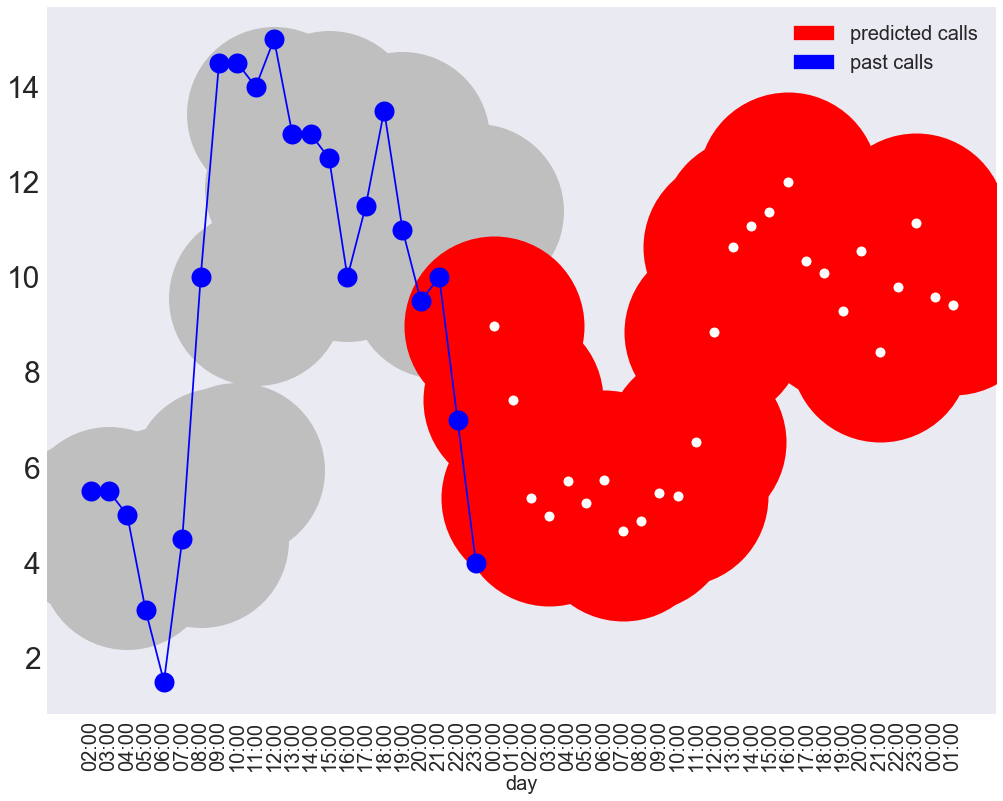

In [103]:
import matplotlib.patches as mpatches

ax=plt.gca()
ax.set_xticks(x_pred)

xfmt = md.DateFormatter('%H:00')
ax.xaxis.set_major_formatter(xfmt)
plt.xticks( rotation=90 )

n_test = len(x_test)
n_pred= len(x_pred)

plt.plot(x_pred[0:n_test], y_pred[0:n_test],'.', color = '0.75', markersize=350)
plt.plot(x_pred[n_test:n_pred], y_pred[n_test:n_pred],'.r', markersize=360)
plt.plot(x_pred[n_test:n_pred], y_pred[n_test:n_pred],'.w', markersize=20)
#plt.plot(x_pred[(n_test):n_pred], y_pred[(n_test):n_pred],'.w', markersize=20)

#plt.plot(x_pred, y_pred,'.r', markersize=240)
#plt.plot(x_pred[0:y_test, y_pred,'.r', markersize=240)
#plt.plot(x_pred, y_pred,'.w', markersize=20)
#plt.plot(x_pred, y_pred,'-w', markersize=20)
plt.plot(x_test, y_test,'-b', markersize=40)
plt.plot(x_test, y_test,'.b', markersize=40)
plt.grid('off')

#red_patch = mpatches.Patch(color='red', label='predicted calls')
blue_patch = mpatches.Patch(color='blue', label='past calls')

#plt.xlabel('Time (hour)', fontsize=20)
plt.xlabel('day', fontsize=20)
#plt.ylabel('Calls', fontsize=20)
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off', labelsize=30)
plt.tick_params(axis='x',  labelsize=20)

plt.legend(handles=[red_patch, blue_patch], fontsize=20)
plt.show()

#plt.axis(['00:00', '23:00', 2, 14])

In [658]:
x_test

[]

In [ ]:
time_next



In [787]:
import json

main = {}

v = [[10,100],[0,80]]
coo = []
coo = [{"coordinates": i} for i in v]
main["features"] = [{"geometry": i} for i in coo]


json_data = json.dumps(main)
json_data
type(v)

list

In [105]:
import numpy as np
import pandas as pd
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import (Exchangeable,
    Independence,Autoregressive)
from statsmodels.genmod.families import Poisson

data = pd.read_csv("epil.csv")
print(data.head())

fam = Poisson()
ind = Independence()
model1 = GEE.from_formula("y ~ age + trt + base", "subject", data, cov_struct=ind, family=fam)
result1 = model1.fit()
print(result1.summary())


FileNotFoundError: File b'epil.csv' does not exist

In [ ]:
pd.to_datetime(time).hour
